# Udacity Intro to Machine Learning Final Project - Matt Thomson


In this project, I built an algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset. The objective is to acheive both precision and recall above 0.30 .


## collecting initial dataset
First we retreive the project's dataset. Selecting all available features.

In [1]:
%matplotlib inline
import pickle
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

In [2]:
all_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 
                 'director_fees', 'to_messages', 'from_messages', 'from_this_person_to_poi']
label_names = ['poi']

## cleaning up the data
Removing two people from the dataset who are clearly not people: 

In [3]:
for person in ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK']:
    del data_dict[person]

## feature selection
Looking at the data there where many NaN values. These are replaced by 0's in the future but a feature that is mostly NaN will probably provide little valaue. As such we remove all features with more than 50% missing data.

In [4]:
num_people = len(data_dict)
feature_selection = []
print('NaN Count:')
for feature in all_features:
    nan_count = 0
    for person in data_dict:
        if data_dict[person][feature] == 'NaN':
            nan_count +=1
    if nan_count < num_people * 0.50: # max % missing
        feature_selection.append(feature)
        print('{} -> {}'.format(nan_count, feature))
    else:
        print('{} -> {} (removed)'.format(nan_count, feature))

NaN Count:
50 -> salary
106 -> deferral_payments (removed)
21 -> total_payments
141 -> loan_advances (removed)
63 -> bonus
127 -> restricted_stock_deferred (removed)
96 -> deferred_income (removed)
19 -> total_stock_value
50 -> expenses
43 -> exercised_stock_options
53 -> other
79 -> long_term_incentive (removed)
35 -> restricted_stock
128 -> director_fees (removed)
58 -> to_messages
58 -> from_messages
58 -> from_this_person_to_poi


Lets replace the from_this_person_to_poi feature with a to_poi_ratio feature that represents the percent of emails sent to a person of interest. We can safely delete this feature knowing that its information is fully preserved in the new ratio.

In [5]:
for person in data_dict:
    if type(data_dict[person]['from_this_person_to_poi']) != str and type(data_dict[person]['from_messages']) != str:
        data_dict[person]['to_poi_ratio'] = float(data_dict[person]['from_this_person_to_poi']) / float(
            (data_dict[person]['from_messages']))
    else:
        data_dict[person]['to_poi_ratio'] = 'NaN'
    del data_dict[person]['from_this_person_to_poi']
feature_selection.remove('from_this_person_to_poi')
feature_selection.append('to_poi_ratio')

## data format

Next we convert the data_dict to a np.array for ingestion into sklearn

In [6]:
import numpy as np
def feature_to_array(data, feature_names):    
    return_list = []
    for person in data:
        single_person = []
        for feature in feature_names:
            if type(data[person][feature]) == str and 'NaN' in data[person][feature]:
                single_person.append(0.0)
            else:
                single_person.append(float(data[person][feature]))
        return_list.append(np.array(single_person))
    return return_list


def label_to_array(data, label_name):
    return_list = []
    for person in data:
        return_list.append(int(data[person][label_name]))
    return return_list

labels = label_to_array(data_dict, label_names[0])
features = feature_to_array(data_dict, feature_selection)

## stats and viewing the data
Lets now take a look at boxplots for each feature and make sure everything looks right. Then print the top 3 values for each feature looking for large outliers.

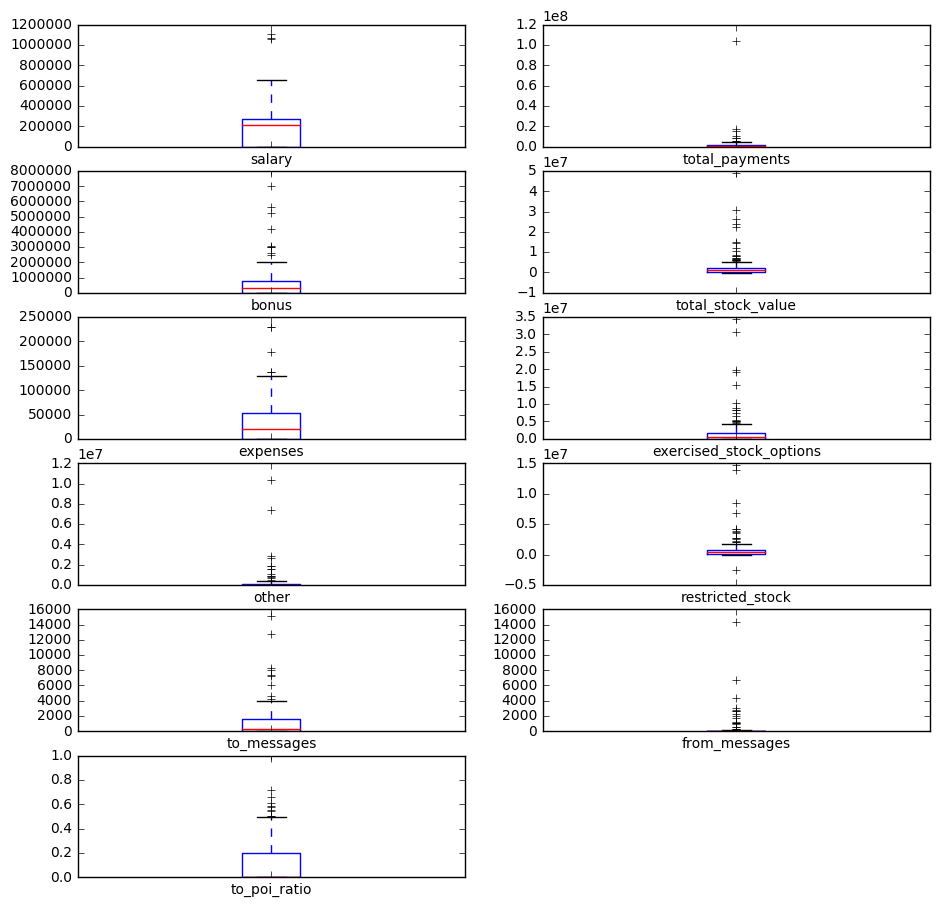

In [7]:
import matplotlib.pyplot as plt
feature_data = np.array(features).transpose()
plt.figure(figsize=(11,11))
for i in range(len(feature_selection)):
    plt.subplot(6, 2, i+1)
    plt.boxplot(feature_data[i])
    plt.xticks([1], [feature_selection[i]])
plt.show()

## algorythm 1 - linear svc

In [8]:
from sklearn.svm import LinearSVC

## tuning 1 - linear svc
We are using cross validation to help make up for the small sample set. We vary the parameter C and are looking for when the precision and recal are both above 0.3

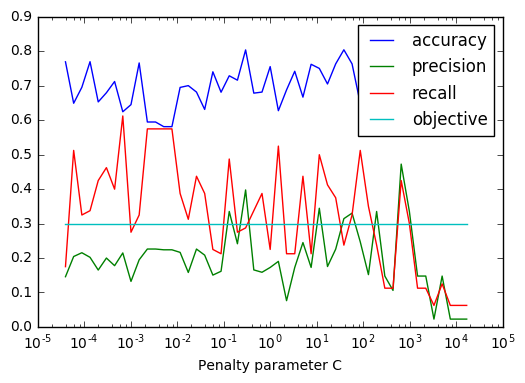

In [9]:
from sklearn.cross_validation import cross_val_score
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt

scoring_methods = ['accuracy', 'precision', 'recall']
c_vals = []
for i in range(-25,25):
    c_vals.append(1.5 ** i)

for method in scoring_methods:
    results = []
    for c in c_vals:
        clf = LinearSVC(random_state = 42, C = c)
        results.append(cross_val_score(clf, features, labels, cv = 4, scoring=method).mean())
    plt.plot(c_vals, results, label=method)
    
plt.plot(c_vals, [0.3]* len(c_vals), label= 'objective') # this is the goal line.
    
plt.legend()
plt.xlabel('Penalty parameter C')
plt.xscale('log')
plt.show()

#### C = 10^3 looks good!
Generally however I am not impressed by the above chart. It shows no distinct direction or maximum performance for a value of C. Ideally this chart would show a single peak where the classifier performs best. The cause of this is most likely the small dataset. 

## validation 1 - linear svc

In [15]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
features_train, features_test, labels_train, labels_test = train_test_split(
    features, labels, test_size=0.25, random_state=0)

clf = LinearSVC(random_state = 42, C = 10**3)
clf.fit(features_train, labels_train)
labels_predict = clf.predict(features_test)
print('Example Confusion Matrix')
print(confusion_matrix(labels_test, labels_predict))

print('')
print('Linear SVC Performance')
for scoring_method in scoring_methods:
    print(scoring_method,cross_val_score(clf, features, labels, cv = 4, scoring=scoring_method).mean())

Example Confusion Matrix
[[ 5 25]
 [ 0  6]]

Linear SVC Performance
accuracy 0.818532818533
precision 0.335227272727
recall 0.3


I've provided an example confusion matrix. On this train/test set there where many false positives. As you can see we narrowly acheived our objective of precision and recal above 0.3.

## algorythm 2 - k neighbors classifier

In [11]:
from sklearn.neighbors import KNeighborsClassifier

## tuning 2 - k neighbors classifier

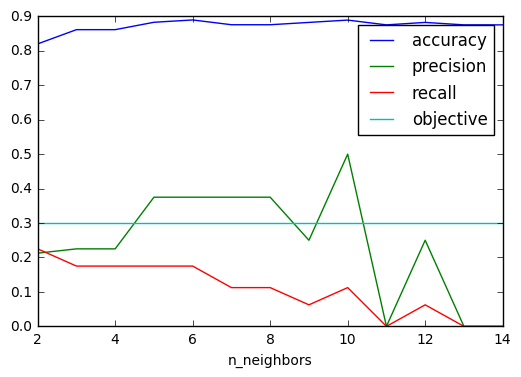

In [12]:
scoring_methods = ['accuracy', 'precision', 'recall']
n_vals = list(range(2, 15))

for method in scoring_methods:
    results = []
    for n in n_vals:
        clf = KNeighborsClassifier(n_neighbors = n, weights = 'distance')
        results.append(cross_val_score(clf, features, labels, cv = 4, scoring=method).mean())
    plt.plot(n_vals, results, label=method)
    
plt.plot(n_vals, [0.3]* len(n_vals), label= 'objective') # this is the goal line.
plt.legend()
plt.xlabel('n_neighbors')
plt.show()

We do not acheive our objective with this algorythm. The recall is not adequate. Selecting a N of 3 or 4 should provide us with the best performance for this classifier.

## validation 2 - k neighbors classifier

In [13]:
clf = KNeighborsClassifier(n_neighbors = 3, weights = 'distance')
clf.fit(features_train, labels_train)
labels_predict = clf.predict(features_test)
print('Example Confusion Matrix')
print(confusion_matrix(labels_test, labels_predict))

print('')
print('K Neighbors SVC Performance')
for scoring_method in scoring_methods:
    print(scoring_method,cross_val_score(clf, features, labels, cv = 4, scoring=scoring_method).mean())

Example Confusion Matrix
[[29  1]
 [ 4  2]]

K Neighbors SVC Performance
accuracy 0.86138996139
precision 0.225
recall 0.175


# conclusion
K-Neighbors was unable to acheive adequate accuracy with the given features. Using a LinearSVC with a C value of 10^3 enabled me to acheive an accuracy of 0.819, precision of 0.335 and recall of 0.3. This classifier would enable investigators to identify possible persons of interest within Enron. 

Improvements could be made by having features with more data integrity. Making lets say 90% of persons to be populated for each feature.

One thing to note is that the feature from_this_person_to_poi would require already knowing all other persons of interest. This would be unavailable at the begining of an investigation. As such using it may have given an artificially better performance.  